In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
load_from = pd.to_datetime('1995-01-01')
train_start_date = pd.to_datetime('2000-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2025-07-07')

In [6]:
# Load data on SPX and VIX
spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [7]:
spx_data.index = pd.to_datetime(spx_data.index.date)
vix_data.index = pd.to_datetime(vix_data.index.date)

spx = spx_data['Close']
vix = vix_data['Close'] / 100

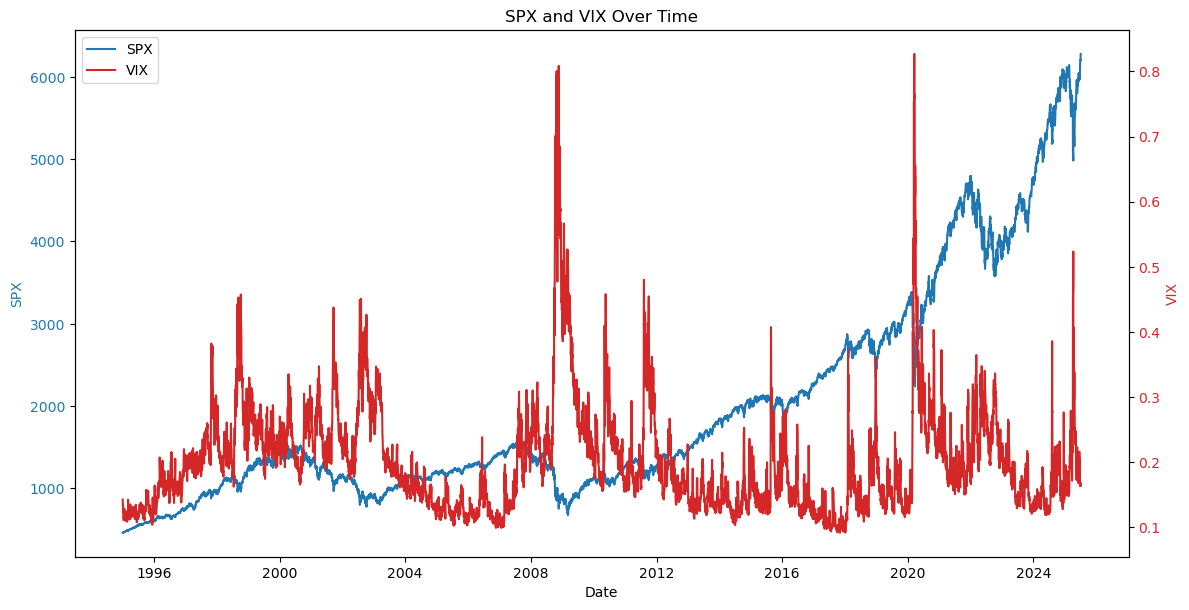

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('SPX', color='tab:blue')
ax1.plot(spx.index, spx.values, color='tab:blue', label='SPX')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('VIX', color='tab:red')
ax2.plot(vix.index, vix.values, color='tab:red', label='VIX')
ax2.tick_params(axis='y', labelcolor='tab:red')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout()
plt.title('SPX and VIX Over Time')
plt.show()

Average business days between observations: 1.45
Delta = 0.08333333333333333 years, which is approximately 21 trading days

First few rows of results:
                    SPX         VWAP          lag          min          max
2020-01-02  3257.850098  3257.850098  3257.850098  3257.850098  3257.850098
2020-01-03  3234.850098  3246.350098  3257.850098  3234.850098  3257.850098
2020-01-06  3246.280029  3246.326742  3257.850098  3234.850098  3257.850098
2020-01-07  3237.179932  3244.040039  3257.850098  3234.850098  3257.850098
2020-01-08  3253.050049  3245.842041  3257.850098  3234.850098  3257.850098

Last few rows of results:
                    SPX         VWAP          lag          min          max
2025-06-27  6173.069824  6010.378092  5888.549805  5911.689941  6173.069824
2025-06-30  6204.950195  6024.320010  5912.169922  5911.689941  6204.950195
2025-07-01  6198.009766  6037.954288  5911.689941  5935.939941  6204.950195
2025-07-02  6227.419922  6051.834287  5935.939941  5939.299805

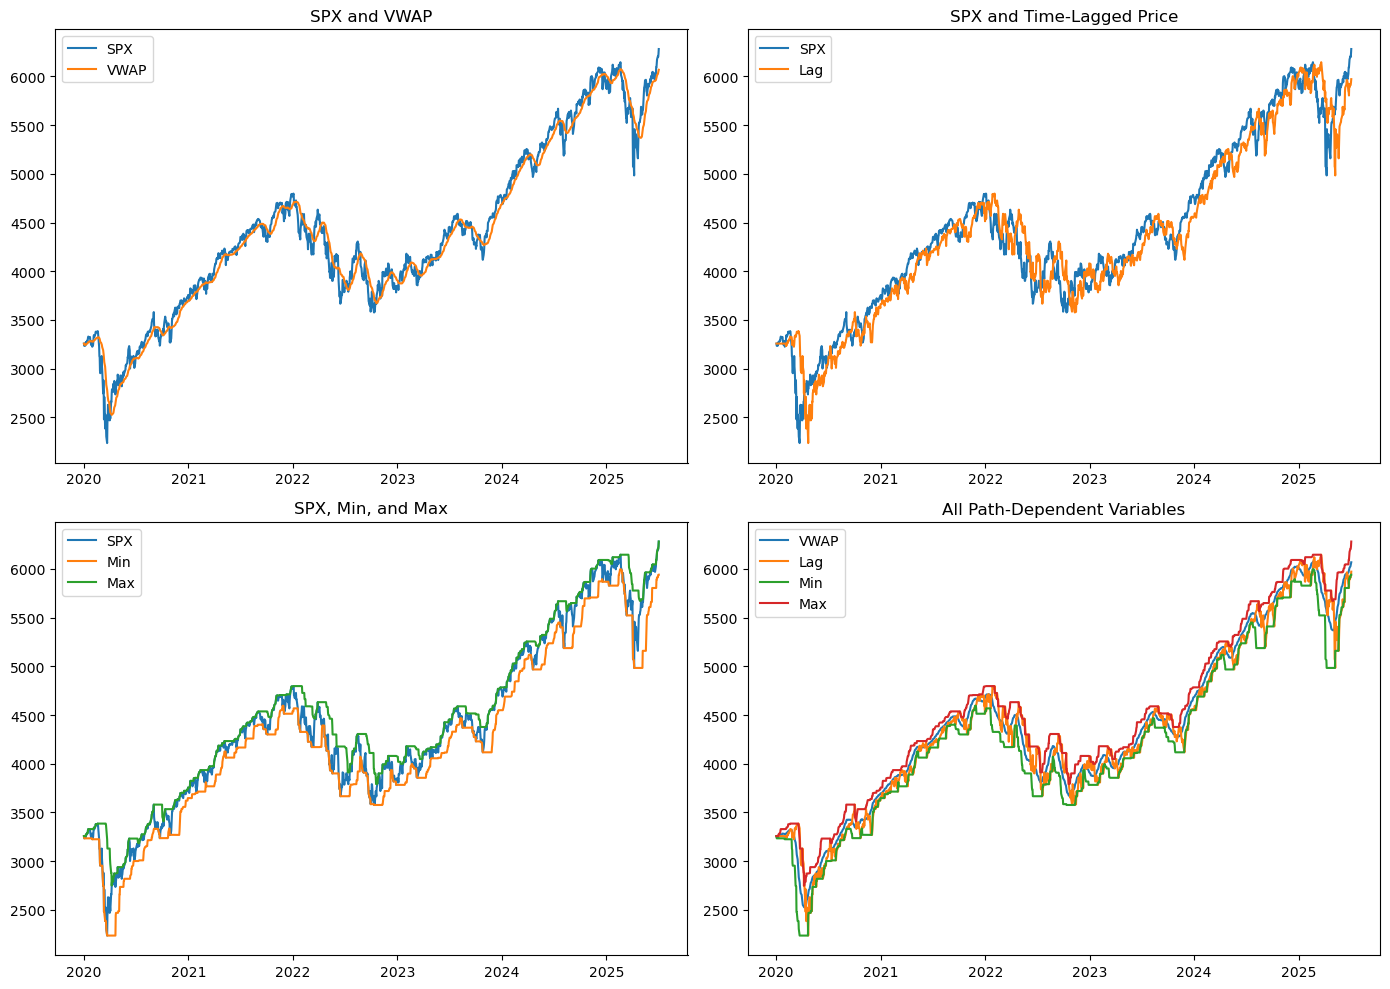

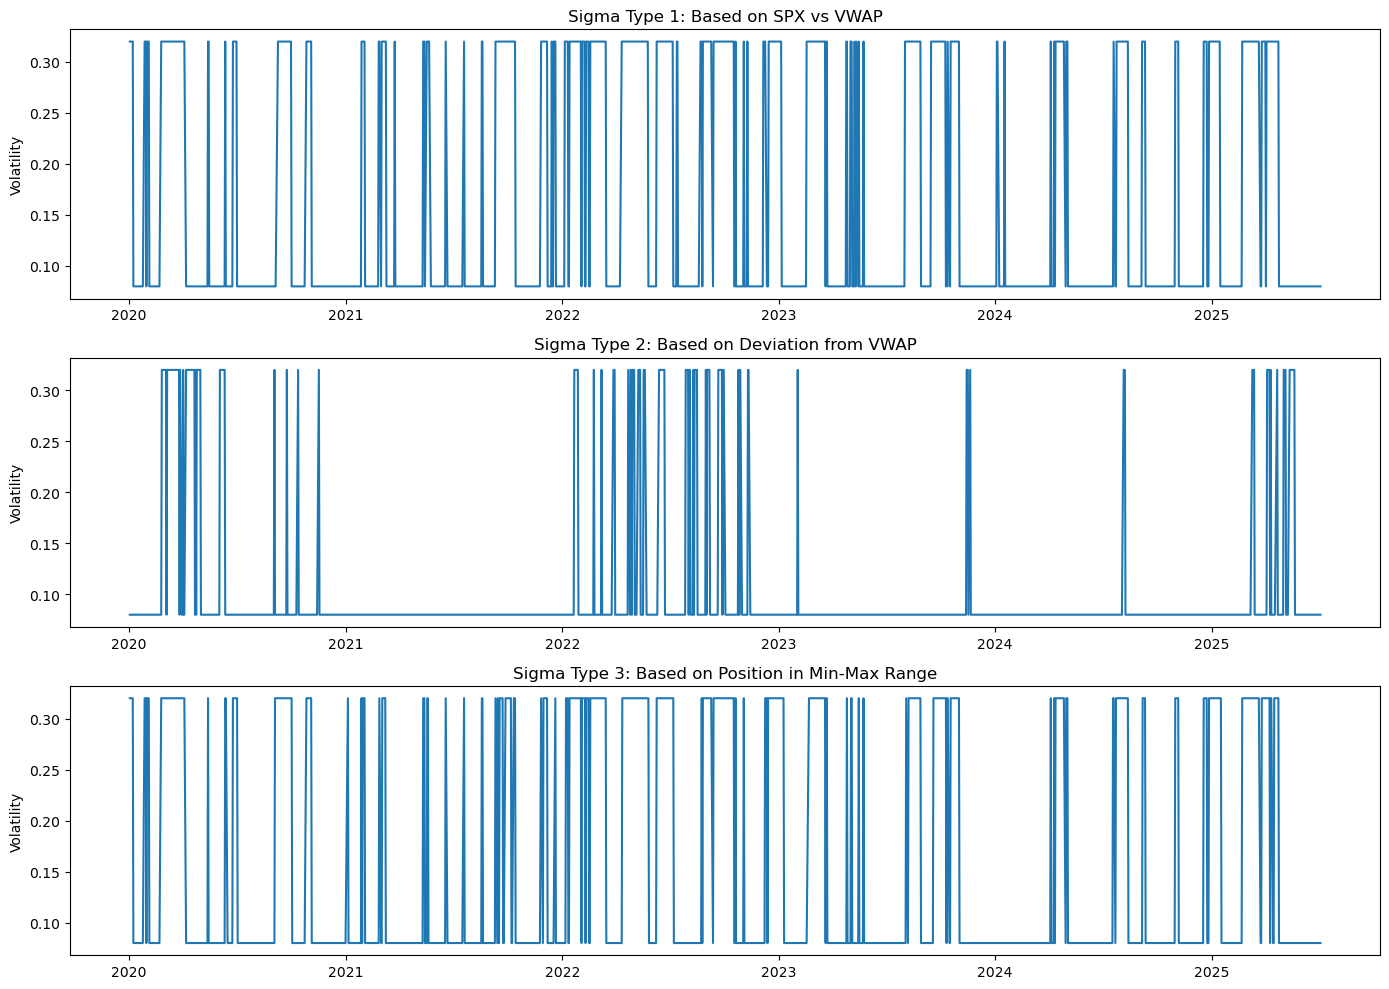


Results saved to 'SPX_pdv_results_2020_2025.csv'


In [9]:
import datetime as dt

# Filter data for 2020-2025
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2025-07-07')  # Using the end date from your notebook
spx_filtered = spx.loc[start_date:end_date]

# Calculate business days between each data point (assuming trading days)
delta_days = np.diff(spx_filtered.index.values) / np.timedelta64(1, 'D')
delta_days = np.append(delta_days, 0)  # Add a zero for the last day
avg_dt = np.mean(delta_days[delta_days > 0])  # Average business days between observations
print(f"Average business days between observations: {avg_dt:.2f}")

# Parameters
Delta = 1/12  # 1 month window in years (as specified)
dt_annual = 1/252  # Assuming ~252 trading days per year
days_in_Delta = int(Delta * 252)  # Approximate number of trading days in Delta

print(f"Delta = {Delta} years, which is approximately {days_in_Delta} trading days")

# Initialize dataframe to store the results
results_df = pd.DataFrame(index=spx_filtered.index)
results_df['SPX'] = spx_filtered.values

# Function to calculate path-dependent variables
def calculate_pdv(prices, window_days):
    """
    Calculate path-dependent variables based on pdv_model.py logic
    
    Args:
        prices: Series of prices
        window_days: Size of the rolling window in trading days
    
    Returns:
        Dictionary with VWAP, lag, min, max values
    """
    result = {}
    
    # VWAP (simple moving average as we don't have volume data)
    result['VWAP'] = prices.rolling(window=window_days, min_periods=1).mean()
    
    # Time lag
    result['lag'] = prices.shift(window_days).fillna(prices.iloc[0])
    
    # Min and max in the window
    result['min'] = prices.rolling(window=window_days, min_periods=1).min()
    result['max'] = prices.rolling(window=window_days, min_periods=1).max()
    
    return result

# Calculate path-dependent variables
pdv_results = calculate_pdv(results_df['SPX'], days_in_Delta)

# Add to results dataframe
for key, values in pdv_results.items():
    results_df[key] = values

# Display the first and last few rows
print("\nFirst few rows of results:")
print(results_df.head())

print("\nLast few rows of results:")
print(results_df.tail())

# Plot the results
plt.figure(figsize=(14, 10))

# Plot SPX and VWAP
plt.subplot(2, 2, 1)
plt.plot(results_df.index, results_df['SPX'], label='SPX')
plt.plot(results_df.index, results_df['VWAP'], label='VWAP')
plt.title('SPX and VWAP')
plt.legend()

# Plot SPX and lag
plt.subplot(2, 2, 2)
plt.plot(results_df.index, results_df['SPX'], label='SPX')
plt.plot(results_df.index, results_df['lag'], label='Lag')
plt.title('SPX and Time-Lagged Price')
plt.legend()

# Plot SPX, min and max
plt.subplot(2, 2, 3)
plt.plot(results_df.index, results_df['SPX'], label='SPX')
plt.plot(results_df.index, results_df['min'], label='Min')
plt.plot(results_df.index, results_df['max'], label='Max')
plt.title('SPX, Min, and Max')
plt.legend()

# Plot all path-dependent variables
plt.subplot(2, 2, 4)
plt.plot(results_df.index, results_df['VWAP'], label='VWAP')
plt.plot(results_df.index, results_df['lag'], label='Lag')
plt.plot(results_df.index, results_df['min'], label='Min')
plt.plot(results_df.index, results_df['max'], label='Max')
plt.title('All Path-Dependent Variables')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate example sigma values based on pdv_model.py sigma functions
# We'll use sigma_type=1 as an example
vol_cap = 0.32
vol_floor = 0.08

# Sigma type 1: σ(t,S,X) = vol_cap if S <= X (VWAP) else vol_floor
results_df['sigma_type1'] = np.where(results_df['SPX'] <= results_df['VWAP'], vol_cap, vol_floor)

# For sigma type 2, we need kappa and sigma0 parameters
kappa = 0.8
sigma0 = 0.2

# Sigma type 2: based on deviation of price from VWAP
threshold = kappa * sigma0 * np.sqrt(Delta)
results_df['sigma_type2'] = np.where(
    abs(results_df['SPX'] / results_df['VWAP'] - 1) > threshold,
    vol_cap,
    vol_floor
)

# For sigma type 3, we need min and max values
# σ(t,S,X) = vol_cap if (S - min) / (max - min) <= 1/2 else vol_floor
results_df['sigma_type3'] = np.where(
    (results_df['SPX'] - results_df['min']) / (results_df['max'] - results_df['min'] + 1e-8) <= 0.5,
    vol_cap,
    vol_floor
)

# Plot the calculated sigma values
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(results_df.index, results_df['sigma_type1'])
plt.title('Sigma Type 1: Based on SPX vs VWAP')
plt.ylabel('Volatility')

plt.subplot(3, 1, 2)
plt.plot(results_df.index, results_df['sigma_type2'])
plt.title('Sigma Type 2: Based on Deviation from VWAP')
plt.ylabel('Volatility')

plt.subplot(3, 1, 3)
plt.plot(results_df.index, results_df['sigma_type3'])
plt.title('Sigma Type 3: Based on Position in Min-Max Range')
plt.ylabel('Volatility')

plt.tight_layout()
plt.show()

# Save the results to a CSV file
results_df.to_csv('SPX_pdv_results_2020_2025.csv')
print("\nResults saved to 'SPX_pdv_results_2020_2025.csv'")

In [10]:
# Approximating the sigma function using VIX data as target
# VIX represents market-implied volatility, which is a good proxy for the sigma function

# First, let's filter the VIX data for the same period as our SPX data
vix_filtered = vix.loc[start_date:end_date]

# Add VIX to our results dataframe
results_df['VIX'] = vix_filtered

# Check for any missing values in either SPX or VIX
print(f"Missing values in SPX: {results_df['SPX'].isna().sum()}")
print(f"Missing values in VIX: {results_df['VIX'].isna().sum()}")

# Create a complete dataset by dropping any rows with missing values
model_df = results_df.dropna().copy()
print(f"Shape of model dataframe after dropping NA: {model_df.shape}")

# Display the first few rows of the aligned dataset
print("\nFirst few rows of the model dataframe:")
print(model_df[['SPX', 'VWAP', 'lag', 'min', 'max', 'VIX']].head())

# Let's create features that might be useful for predicting VIX
model_df['SPX_to_VWAP'] = model_df['SPX'] / model_df['VWAP']
model_df['SPX_to_lag'] = model_df['SPX'] / model_df['lag']
model_df['position_in_range'] = (model_df['SPX'] - model_df['min']) / (model_df['max'] - model_df['min'] + 1e-8)
model_df['range_width'] = (model_df['max'] - model_df['min']) / model_df['SPX']
model_df['SPX_return'] = model_df['SPX'].pct_change().fillna(0)
model_df['SPX_return_squared'] = model_df['SPX_return'] ** 2  # Volatility proxy

# Create lagged features (last 5 days)
for i in range(1, 6):
    model_df[f'SPX_lag_{i}'] = model_df['SPX'].shift(i)
    model_df[f'SPX_return_lag_{i}'] = model_df['SPX_return'].shift(i)
    model_df[f'VIX_lag_{i}'] = model_df['VIX'].shift(i)

# Drop rows with NaN values after creating lagged features
model_df = model_df.dropna().copy()
print(f"Shape after adding lagged features and dropping NAs: {model_df.shape}")

Missing values in SPX: 0
Missing values in VIX: 0
Shape of model dataframe after dropping NA: (1383, 9)

First few rows of the model dataframe:
                    SPX         VWAP          lag          min          max  \
2020-01-02  3257.850098  3257.850098  3257.850098  3257.850098  3257.850098   
2020-01-03  3234.850098  3246.350098  3257.850098  3234.850098  3257.850098   
2020-01-06  3246.280029  3246.326742  3257.850098  3234.850098  3257.850098   
2020-01-07  3237.179932  3244.040039  3257.850098  3234.850098  3257.850098   
2020-01-08  3253.050049  3245.842041  3257.850098  3234.850098  3257.850098   

               VIX  
2020-01-02  0.1247  
2020-01-03  0.1402  
2020-01-06  0.1385  
2020-01-07  0.1379  
2020-01-08  0.1345  
Shape after adding lagged features and dropping NAs: (1378, 30)


In [11]:
# Approximating the sigma function using VIX data as target
# VIX represents market-implied volatility, which is a good proxy for the sigma function

# First, let's filter the VIX data for the same period as our SPX data
vix_filtered = vix.loc[start_date:end_date]

# Add VIX to our results dataframe
results_df['VIX'] = vix_filtered

# Check for any missing values in either SPX or VIX
print(f"Missing values in SPX: {results_df['SPX'].isna().sum()}")
print(f"Missing values in VIX: {results_df['VIX'].isna().sum()}")

# Create a complete dataset by dropping any rows with missing values
model_df = results_df.dropna().copy()
print(f"Shape of model dataframe after dropping NA: {model_df.shape}")

# Display the first few rows of the aligned dataset
print("\nFirst few rows of the model dataframe:")
print(model_df[['SPX', 'VWAP', 'lag', 'min', 'max', 'VIX']].head())

# Let's create features that might be useful for predicting VIX
model_df['SPX_to_VWAP'] = model_df['SPX'] / model_df['VWAP']
model_df['SPX_to_lag'] = model_df['SPX'] / model_df['lag']
model_df['position_in_range'] = (model_df['SPX'] - model_df['min']) / (model_df['max'] - model_df['min'] + 1e-8)
model_df['range_width'] = (model_df['max'] - model_df['min']) / model_df['SPX']
model_df['SPX_return'] = model_df['SPX'].pct_change().fillna(0)
model_df['SPX_return_squared'] = model_df['SPX_return'] ** 2  # Volatility proxy

# Create lagged features (last 5 days)
for i in range(1, 6):
    model_df[f'SPX_lag_{i}'] = model_df['SPX'].shift(i)
    model_df[f'SPX_return_lag_{i}'] = model_df['SPX_return'].shift(i)
    model_df[f'VIX_lag_{i}'] = model_df['VIX'].shift(i)

# Drop rows with NaN values after creating lagged features
model_df = model_df.dropna().copy()
print(f"Shape after adding lagged features and dropping NAs: {model_df.shape}")

# Split data into training and testing sets
# Use data up to 2024 for training, and 2025 for testing
train_data = model_df[model_df.index < pd.to_datetime('2025-01-01')]
test_data = model_df[model_df.index >= pd.to_datetime('2025-01-01')]

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Missing values in SPX: 0
Missing values in VIX: 0
Shape of model dataframe after dropping NA: (1383, 9)

First few rows of the model dataframe:
                    SPX         VWAP          lag          min          max  \
2020-01-02  3257.850098  3257.850098  3257.850098  3257.850098  3257.850098   
2020-01-03  3234.850098  3246.350098  3257.850098  3234.850098  3257.850098   
2020-01-06  3246.280029  3246.326742  3257.850098  3234.850098  3257.850098   
2020-01-07  3237.179932  3244.040039  3257.850098  3234.850098  3257.850098   
2020-01-08  3253.050049  3245.842041  3257.850098  3234.850098  3257.850098   

               VIX  
2020-01-02  0.1247  
2020-01-03  0.1402  
2020-01-06  0.1385  
2020-01-07  0.1379  
2020-01-08  0.1345  
Shape after adding lagged features and dropping NAs: (1378, 30)
Training data shape: (1253, 30)
Testing data shape: (125, 30)


In [12]:
# Create feature sets for different models
# Model 1: Basic features - SPX, VWAP, lag, min, max
features_basic = ['SPX', 'VWAP', 'lag', 'min', 'max']

# Model 2: Advanced features - ratios and position metrics
features_advanced = [
    'SPX', 
    'VWAP', 'lag', 'min', 'max',
    'SPX_to_VWAP', 'SPX_to_lag', 'position_in_range', 'range_width'
]

# Model 3: Time series features - include lagged values
features_ts = [
    'SPX',
    'VWAP', 'lag', 'min', 'max',
    'SPX_to_VWAP', 'SPX_to_lag', 'position_in_range',
    'SPX_return', 'SPX_return_squared',
    'VIX_lag_1', 'VIX_lag_2', 'VIX_lag_3'
]

# Target variable
target = 'VIX'

# Import necessary libraries for modeling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return rmse, mae, r2

# Scale features for better model performance
scaler = StandardScaler()
X_train_basic = scaler.fit_transform(train_data[features_basic])
X_test_basic = scaler.transform(test_data[features_basic])

X_train_advanced = scaler.fit_transform(train_data[features_advanced])
X_test_advanced = scaler.transform(test_data[features_advanced])

X_train_ts = scaler.fit_transform(train_data[features_ts])
X_test_ts = scaler.transform(test_data[features_ts])

y_train = train_data[target].values
y_test = test_data[target].values

# Model training and evaluation
print("\n--- Model Performance (Training Data) ---")

# Linear Regression with basic features
lr_basic = LinearRegression()
lr_basic.fit(X_train_basic, y_train)
y_train_pred_lr_basic = lr_basic.predict(X_train_basic)
evaluate_model(y_train, y_train_pred_lr_basic, "Linear Regression (Basic Features)")

# Random Forest with advanced features
rf_advanced = RandomForestRegressor(n_estimators=100, random_state=42)
rf_advanced.fit(X_train_advanced, y_train)
y_train_pred_rf_advanced = rf_advanced.predict(X_train_advanced)
evaluate_model(y_train, y_train_pred_rf_advanced, "Random Forest (Advanced Features)")

# XGBoost with time series features
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train_ts, y_train)
y_train_pred_xgb = xgb_model.predict(X_train_ts)
evaluate_model(y_train, y_train_pred_xgb, "XGBoost (Time Series Features)")

print("\n--- Model Performance (Test Data) ---")

# Linear Regression with basic features
y_test_pred_lr_basic = lr_basic.predict(X_test_basic)
lr_basic_metrics = evaluate_model(y_test, y_test_pred_lr_basic, "Linear Regression (Basic Features)")

# Random Forest with advanced features
y_test_pred_rf_advanced = rf_advanced.predict(X_test_advanced)
rf_advanced_metrics = evaluate_model(y_test, y_test_pred_rf_advanced, "Random Forest (Advanced Features)")

# XGBoost with time series features
y_test_pred_xgb = xgb_model.predict(X_test_ts)
xgb_metrics = evaluate_model(y_test, y_test_pred_xgb, "XGBoost (Time Series Features)")




--- Model Performance (Training Data) ---
Linear Regression (Basic Features) - RMSE: 0.0386, MAE: 0.0300, R²: 0.7816
Random Forest (Advanced Features) - RMSE: 0.0065, MAE: 0.0044, R²: 0.9939
XGBoost (Time Series Features) - RMSE: 0.0014, MAE: 0.0010, R²: 0.9997

--- Model Performance (Test Data) ---
Linear Regression (Basic Features) - RMSE: 0.0522, MAE: 0.0458, R²: 0.3541
Random Forest (Advanced Features) - RMSE: 0.0460, MAE: 0.0347, R²: 0.4978
XGBoost (Time Series Features) - RMSE: 0.0240, MAE: 0.0126, R²: 0.8636
Random Forest (Advanced Features) - RMSE: 0.0065, MAE: 0.0044, R²: 0.9939
XGBoost (Time Series Features) - RMSE: 0.0014, MAE: 0.0010, R²: 0.9997

--- Model Performance (Test Data) ---
Linear Regression (Basic Features) - RMSE: 0.0522, MAE: 0.0458, R²: 0.3541
Random Forest (Advanced Features) - RMSE: 0.0460, MAE: 0.0347, R²: 0.4978
XGBoost (Time Series Features) - RMSE: 0.0240, MAE: 0.0126, R²: 0.8636


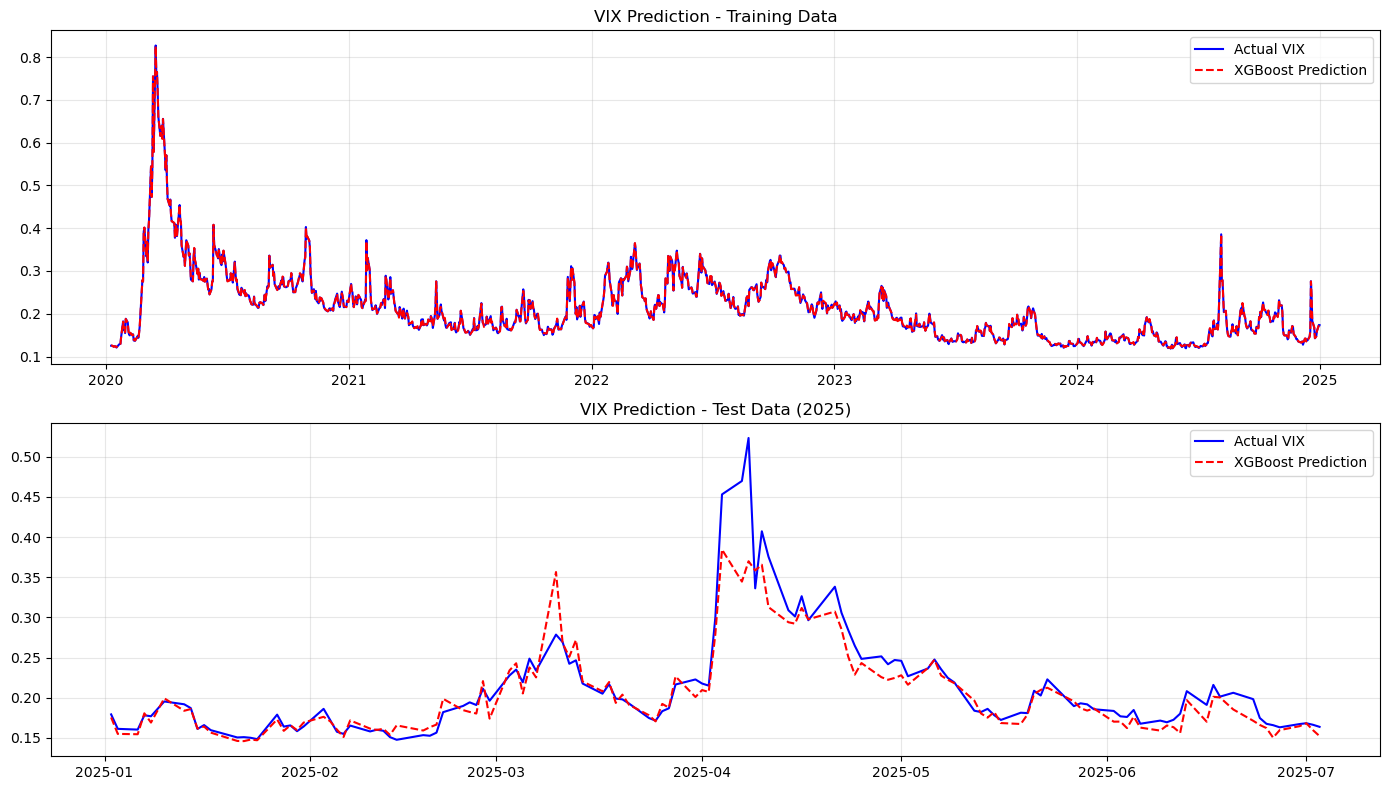

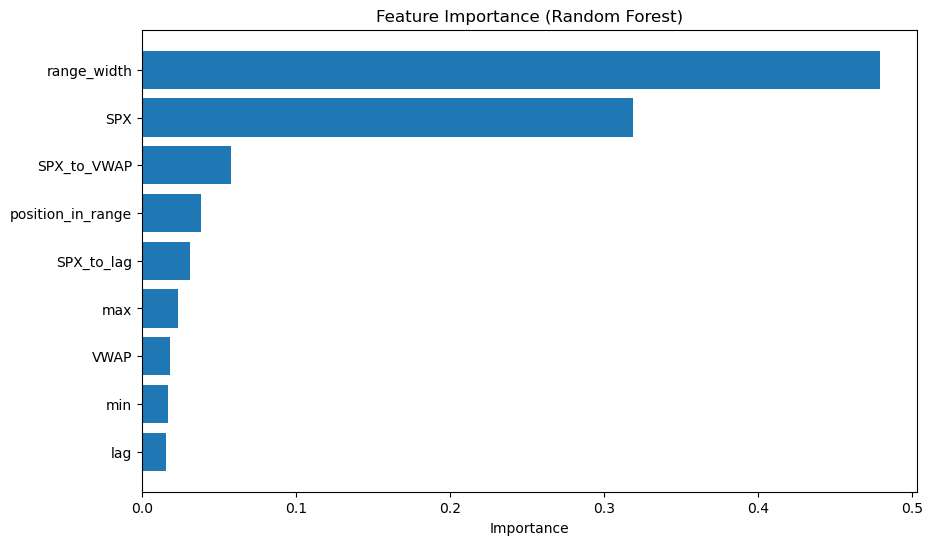

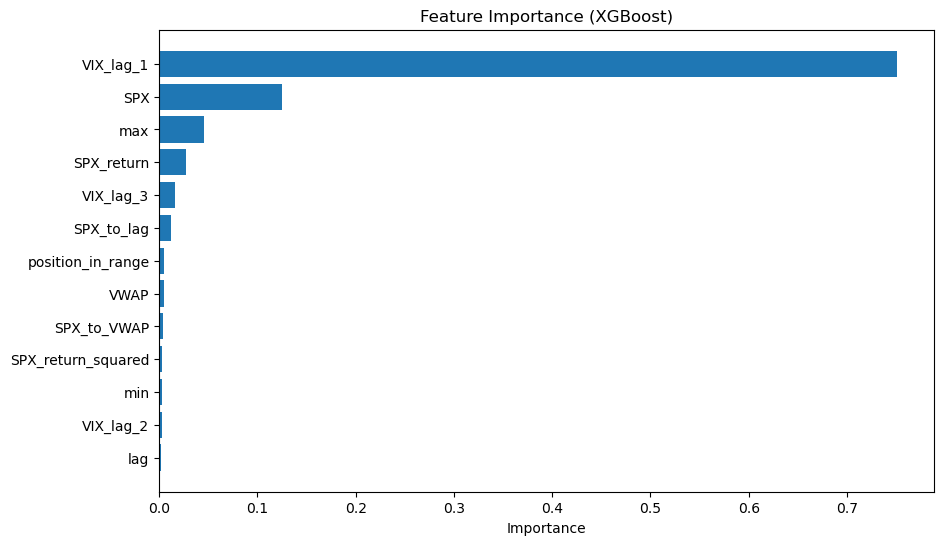

In [13]:
# Visualize predictions
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.title('VIX Prediction - Training Data')
plt.plot(train_data.index, y_train, 'b-', label='Actual VIX')
plt.plot(train_data.index, y_train_pred_xgb, 'r--', label='XGBoost Prediction')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.title('VIX Prediction - Test Data (2025)')
plt.plot(test_data.index, y_test, 'b-', label='Actual VIX')
plt.plot(test_data.index, y_test_pred_xgb, 'r--', label='XGBoost Prediction')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance for Random Forest model
if len(features_advanced) > 0:
    importance = pd.DataFrame({
        'Feature': features_advanced,
        'Importance': rf_advanced.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance (Random Forest)')
    plt.gca().invert_yaxis()
    plt.show()

# Feature importance for XGBoost model
if len(features_ts) > 0:
    importance_xgb = pd.DataFrame({
        'Feature': features_ts,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_xgb['Feature'], importance_xgb['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance (XGBoost)')
    plt.gca().invert_yaxis()
    plt.show()


Latest data point:
Date: 2025-07-03 00:00:00
SPX: 6279.35
VIX: 0.1638

Predicted VIX for the next trading day: 0.1523


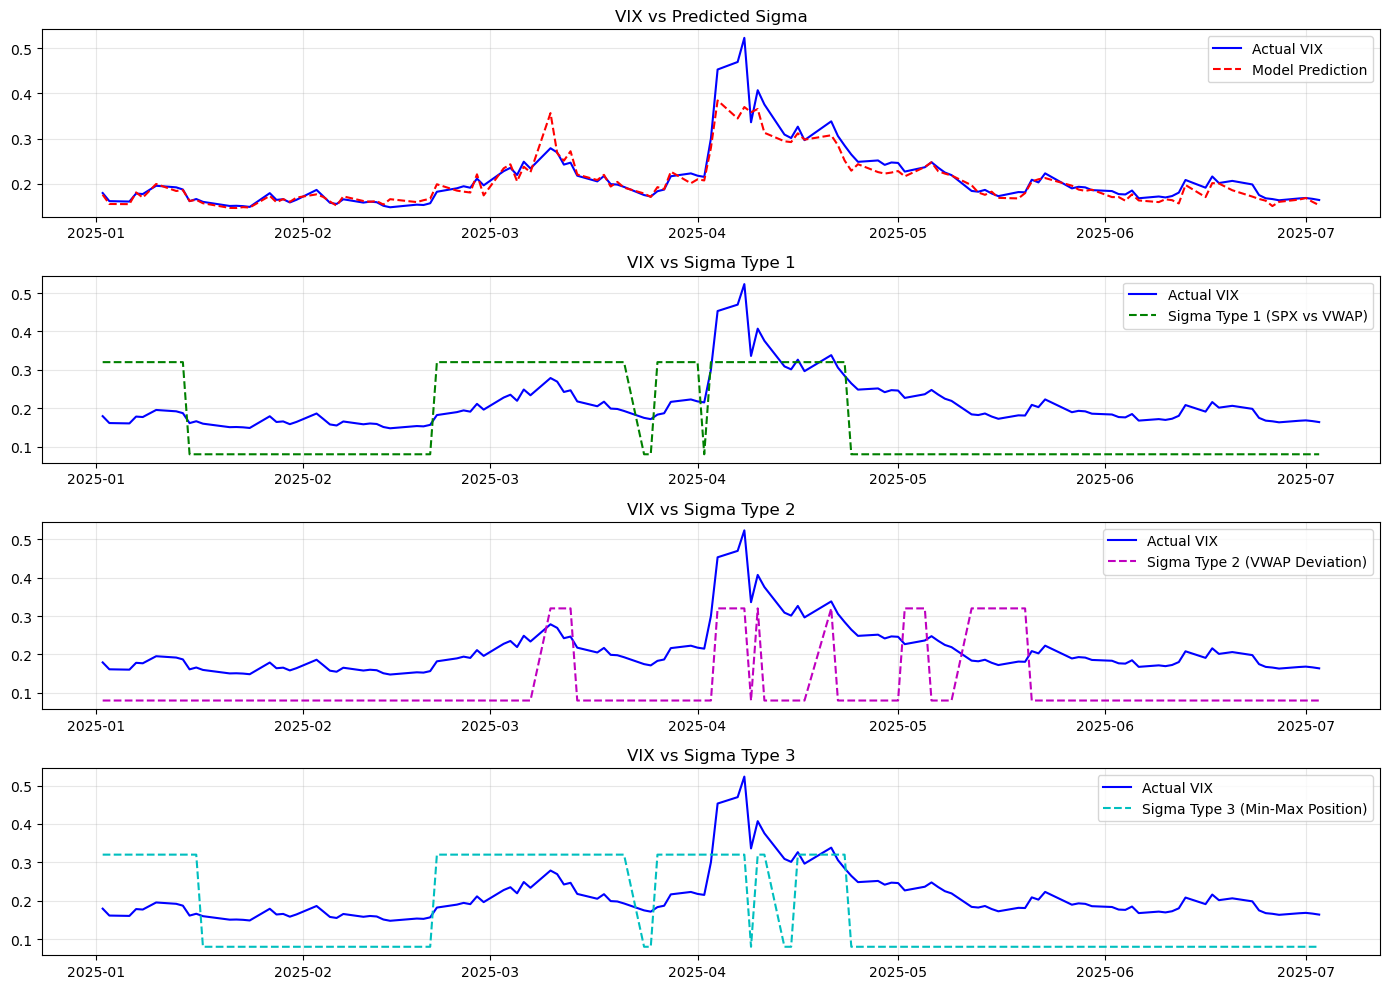


Correlation with VIX:
Model-predicted sigma: 0.9455
Sigma Type 1: 0.4991
Sigma Type 2: 0.4089
Sigma Type 3: 0.3968

Prediction results saved to 'SPX_VIX_predictions.csv'


In [14]:
# Fix warnings and improve prediction functionality
import warnings
from pandas.errors import SettingWithCopyWarning

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.base")
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# One-day ahead prediction
def predict_next_day_vix(model, X_latest, scaler, features):
    """Predict VIX for the next day using the latest available data"""
    X_scaled = scaler.transform([X_latest[features].values.flatten()])
    pred = model.predict(X_scaled)[0]
    return pred

# Get the latest available data point
latest_data = model_df.iloc[-1].copy()

# Print information about the latest data point
print("\nLatest data point:")
print(f"Date: {latest_data.name}")
print(f"SPX: {latest_data['SPX']:.2f}")
print(f"VIX: {latest_data['VIX']:.4f}")

# Predict VIX for the next day using our best model (XGBoost)
next_day_vix_pred = predict_next_day_vix(xgb_model, latest_data, scaler, features_ts)
print(f"\nPredicted VIX for the next trading day: {next_day_vix_pred:.4f}")

# Create a function to generate sigma values from our model
def generate_sigma_from_model(model, data, scaler, features):
    """Generate sigma values using our model predictions"""
    X_scaled = scaler.transform(data[features])
    return model.predict(X_scaled)

# Generate predicted sigma values for the test period
test_data['sigma_model'] = generate_sigma_from_model(xgb_model, test_data, scaler, features_ts)

# Compare predicted sigma with our rule-based sigma types
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(test_data.index, test_data['VIX'], 'b-', label='Actual VIX')
plt.plot(test_data.index, test_data['sigma_model'], 'r--', label='Model Prediction')
plt.title('VIX vs Predicted Sigma')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 2)
plt.plot(test_data.index, test_data['VIX'], 'b-', label='Actual VIX')
plt.plot(test_data.index, test_data['sigma_type1'], 'g--', label='Sigma Type 1 (SPX vs VWAP)')
plt.title('VIX vs Sigma Type 1')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 3)
plt.plot(test_data.index, test_data['VIX'], 'b-', label='Actual VIX')
plt.plot(test_data.index, test_data['sigma_type2'], 'm--', label='Sigma Type 2 (VWAP Deviation)')
plt.title('VIX vs Sigma Type 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 4)
plt.plot(test_data.index, test_data['VIX'], 'b-', label='Actual VIX')
plt.plot(test_data.index, test_data['sigma_type3'], 'c--', label='Sigma Type 3 (Min-Max Position)')
plt.title('VIX vs Sigma Type 3')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation between VIX and each sigma type
corr_model = np.corrcoef(test_data['VIX'], test_data['sigma_model'])[0,1]
corr_type1 = np.corrcoef(test_data['VIX'], test_data['sigma_type1'])[0,1]
corr_type2 = np.corrcoef(test_data['VIX'], test_data['sigma_type2'])[0,1]
corr_type3 = np.corrcoef(test_data['VIX'], test_data['sigma_type3'])[0,1]

print("\nCorrelation with VIX:")
print(f"Model-predicted sigma: {corr_model:.4f}")
print(f"Sigma Type 1: {corr_type1:.4f}")
print(f"Sigma Type 2: {corr_type2:.4f}")
print(f"Sigma Type 3: {corr_type3:.4f}")

# Save the predicted results
prediction_df = pd.DataFrame({
    'Date': test_data.index,
    'SPX': test_data['SPX'],
    'VIX_Actual': test_data['VIX'],
    'VIX_Predicted': test_data['sigma_model'],
    'Sigma_Type1': test_data['sigma_type1'],
    'Sigma_Type2': test_data['sigma_type2'],
    'Sigma_Type3': test_data['sigma_type3']
})

prediction_df.to_csv('SPX_VIX_predictions.csv', index=False)
print("\nPrediction results saved to 'SPX_VIX_predictions.csv'")


--- PDV-Inspired Model Performance ---
PDV-Inspired Model (Training) - RMSE: 0.0141, MAE: 0.0088, R²: 0.9708
PDV-Inspired Model (Testing) - RMSE: 0.0144, MAE: 0.0090, R²: 0.9509

--- Performance Comparison (Test Data) ---
XGBoost Model: RMSE = 0.0240, R² = 0.8636
PDV-Inspired Model: RMSE = 0.0144, R² = 0.9509


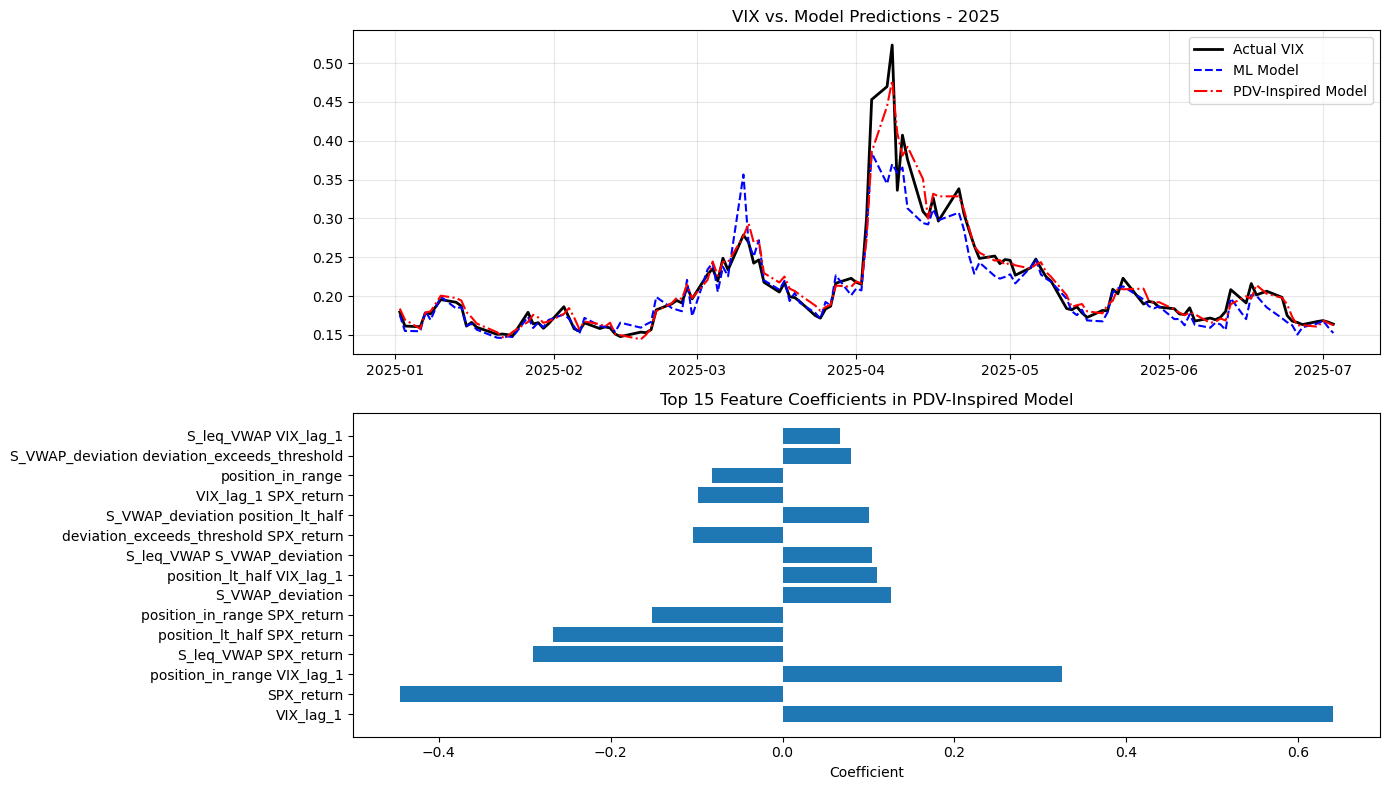

Hybrid Model - RMSE: 0.0147, MAE: 0.0086, R²: 0.9487

--- Final Model Comparison (Test Data) ---
XGBoost Model: RMSE = 0.0240, R² = 0.8636
PDV-Inspired Model: RMSE = 0.0144, R² = 0.9509
Hybrid Model: RMSE = 0.0147, R² = 0.9487


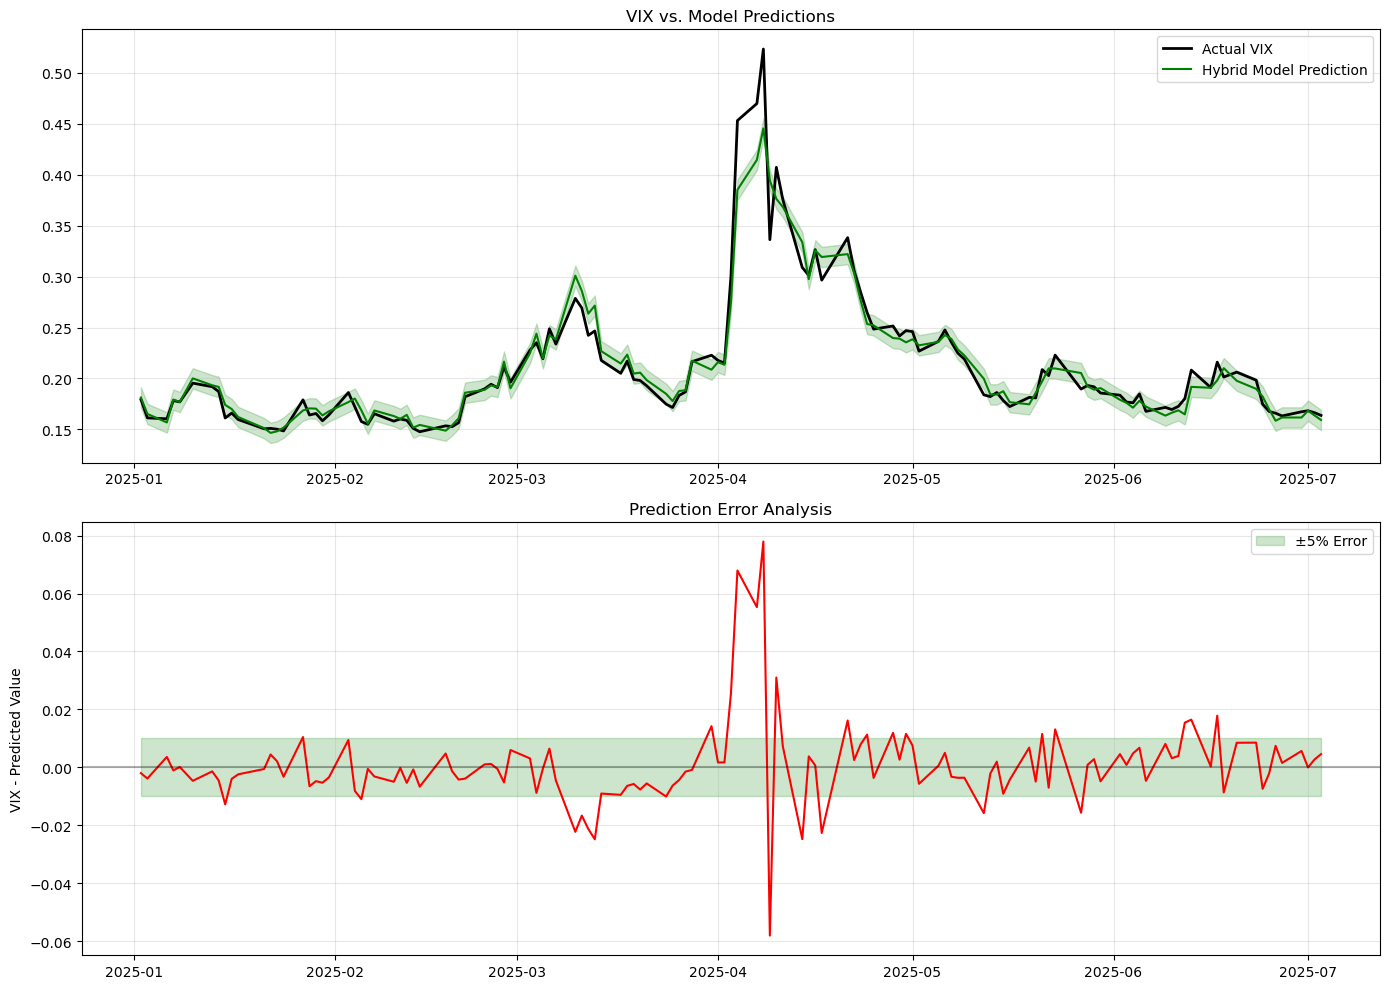


Hybrid VIX prediction for the next trading day: 0.1593


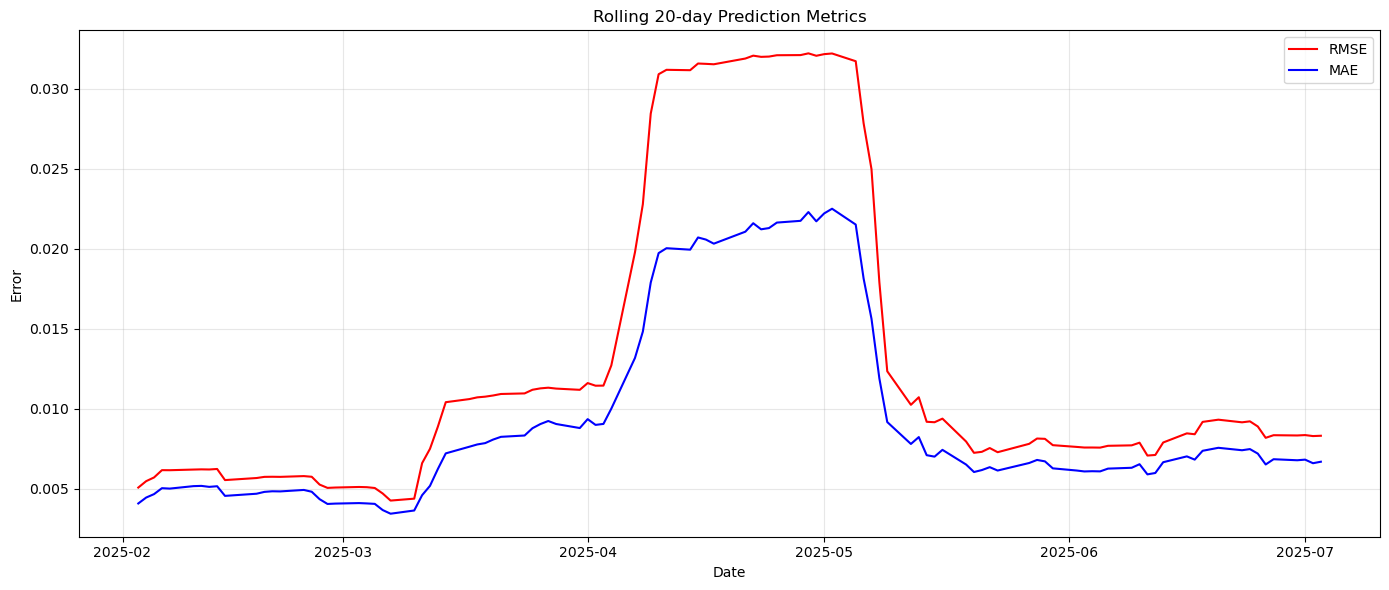


Final prediction results saved to 'SPX_VIX_final_predictions.csv'


In [15]:
# Let's implement a more structured approach to sigma approximation 
# based on the PDV model's sigma function structure

# Create a dataframe focused on the structural relationships in the PDV sigma function
pdv_sigma_df = model_df.copy()

# Add features that directly relate to the logic in PDV model's sigma functions
# For sigma_type 1: σ(t,S,X) = vol_cap * (S <= X) + vol_floor * (S > X)
pdv_sigma_df['S_leq_VWAP'] = (pdv_sigma_df['SPX'] <= pdv_sigma_df['VWAP']).astype(int)

# For sigma_type 2: based on deviation of price from VWAP
# sigma = vol_cap * (abs(S/X - 1) > kappa * sigma0 * sqrt(Delta)) + vol_floor * otherwise
pdv_sigma_df['S_VWAP_deviation'] = abs(pdv_sigma_df['SPX'] / pdv_sigma_df['VWAP'] - 1)
pdv_sigma_df['deviation_threshold'] = kappa * sigma0 * np.sqrt(Delta)
pdv_sigma_df['deviation_exceeds_threshold'] = (
    pdv_sigma_df['S_VWAP_deviation'] > pdv_sigma_df['deviation_threshold']).astype(int)

# For sigma_type 3: based on position in min-max range
pdv_sigma_df['position_lt_half'] = (pdv_sigma_df['position_in_range'] <= 0.5).astype(int)

# Create a more flexible sigma function approximation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Define features for our PDV-inspired model
pdv_features = [
    'S_leq_VWAP', 
    'S_VWAP_deviation', 
    'deviation_exceeds_threshold',
    'position_in_range', 
    'position_lt_half',
    'VIX_lag_1',  # Include previous day's VIX for temporal continuity
    'SPX_return'  # Recent market movement
]

# Split data for PDV-inspired model
pdv_train = pdv_sigma_df[pdv_sigma_df.index < pd.to_datetime('2025-01-01')]
pdv_test = pdv_sigma_df[pdv_sigma_df.index >= pd.to_datetime('2025-01-01')]

X_train_pdv = pdv_train[pdv_features]
y_train_pdv = pdv_train[target]
X_test_pdv = pdv_test[pdv_features]
y_test_pdv = pdv_test[target]

# Create a polynomial model to capture interactions between features
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)),
    ('ridge', Ridge(alpha=0.1))
])

# Train the model
poly_model.fit(X_train_pdv, y_train_pdv)

# Make predictions
y_train_pred_poly = poly_model.predict(X_train_pdv)
y_test_pred_poly = poly_model.predict(X_test_pdv)

# Evaluate
print("\n--- PDV-Inspired Model Performance ---")
pdv_train_metrics = evaluate_model(y_train_pdv, y_train_pred_poly, "PDV-Inspired Model (Training)")
pdv_test_metrics = evaluate_model(y_test_pdv, y_test_pred_poly, "PDV-Inspired Model (Testing)")

# Compare with our best ML model
print("\n--- Performance Comparison (Test Data) ---")
print(f"XGBoost Model: RMSE = {xgb_metrics[0]:.4f}, R² = {xgb_metrics[2]:.4f}")
print(f"PDV-Inspired Model: RMSE = {pdv_test_metrics[0]:.4f}, R² = {pdv_test_metrics[2]:.4f}")

# Add predictions to test dataframe
test_data['sigma_pdv_model'] = y_test_pred_poly

# Visualize PDV-inspired model predictions
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.title('VIX vs. Model Predictions - 2025')
plt.plot(test_data.index, test_data['VIX'], 'k-', linewidth=2, label='Actual VIX')
plt.plot(test_data.index, test_data['sigma_model'], 'b--', label='ML Model')
plt.plot(test_data.index, test_data['sigma_pdv_model'], 'r-.', label='PDV-Inspired Model')
plt.legend()
plt.grid(True, alpha=0.3)

# Show feature weights for PDV-inspired model
ridge_model = poly_model.named_steps['ridge']
poly_features = poly_model.named_steps['poly'].get_feature_names_out(pdv_features)

pdv_importance = pd.DataFrame({
    'Feature': poly_features,
    'Coefficient': ridge_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.subplot(2, 1, 2)
plt.barh(pdv_importance['Feature'][:15], pdv_importance['Coefficient'][:15])
plt.title('Top 15 Feature Coefficients in PDV-Inspired Model')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.show()

# Create a hybrid prediction that combines our models
# Weighted average of ML model and PDV model (30/70 weighting)
test_data['sigma_hybrid'] = 0.3 * test_data['sigma_model'] + 0.7 * test_data['sigma_pdv_model']

# Evaluate hybrid model
hybrid_metrics = evaluate_model(test_data['VIX'], test_data['sigma_hybrid'], "Hybrid Model")

print("\n--- Final Model Comparison (Test Data) ---")
print(f"XGBoost Model: RMSE = {xgb_metrics[0]:.4f}, R² = {xgb_metrics[2]:.4f}")
print(f"PDV-Inspired Model: RMSE = {pdv_test_metrics[0]:.4f}, R² = {pdv_test_metrics[2]:.4f}")
print(f"Hybrid Model: RMSE = {hybrid_metrics[0]:.4f}, R² = {hybrid_metrics[2]:.4f}")

# Plot final comparison
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.title('VIX vs. Model Predictions')
plt.plot(test_data.index, test_data['VIX'], 'k-', linewidth=2, label='Actual VIX')
plt.plot(test_data.index, test_data['sigma_hybrid'], 'g-', label='Hybrid Model Prediction')
plt.fill_between(test_data.index, 
                 test_data['sigma_hybrid'] - 0.01, 
                 test_data['sigma_hybrid'] + 0.01, 
                 color='g', alpha=0.2)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.title('Prediction Error Analysis')
plt.plot(test_data.index, test_data['VIX'] - test_data['sigma_hybrid'], 'r-')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.fill_between(test_data.index, -0.01, 0.01, color='g', alpha=0.2, label='±5% Error')
plt.ylabel('VIX - Predicted Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate the next day's prediction using our hybrid approach
latest_data_pdv = pdv_sigma_df.iloc[-1][pdv_features]
next_day_pdv_pred = poly_model.predict([latest_data_pdv])[0]
next_day_hybrid_pred = 0.3 * next_day_vix_pred + 0.7 * next_day_pdv_pred

print(f"\nHybrid VIX prediction for the next trading day: {next_day_hybrid_pred:.4f}")

# Create a rolling prediction visualization
# For each day in 2025, show prediction accuracy of the hybrid model
rolling_window = 20  # 20 trading days ≈ 1 month
test_data['rolling_rmse'] = np.nan
test_data['rolling_mae'] = np.nan

for i in range(rolling_window, len(test_data)):
    window_actual = test_data['VIX'].iloc[i-rolling_window:i]
    window_pred = test_data['sigma_hybrid'].iloc[i-rolling_window:i]
    test_data.loc[test_data.index[i], 'rolling_rmse'] = np.sqrt(mean_squared_error(window_actual, window_pred))
    test_data.loc[test_data.index[i], 'rolling_mae'] = mean_absolute_error(window_actual, window_pred)

plt.figure(figsize=(14, 6))
plt.title(f'Rolling {rolling_window}-day Prediction Metrics')
plt.plot(test_data.index[rolling_window:], test_data['rolling_rmse'][rolling_window:], 'r-', label='RMSE')
plt.plot(test_data.index[rolling_window:], test_data['rolling_mae'][rolling_window:], 'b-', label='MAE')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save the final predictions with all models
final_df = pd.DataFrame({
    'Date': test_data.index,
    'SPX': test_data['SPX'],
    'VIX_Actual': test_data['VIX'],
    'ML_Prediction': test_data['sigma_model'],
    'PDV_Prediction': test_data['sigma_pdv_model'],
    'Hybrid_Prediction': test_data['sigma_hybrid'],
    'Rule_Based_1': test_data['sigma_type1'],
    'Rule_Based_2': test_data['sigma_type2'],
    'Rule_Based_3': test_data['sigma_type3']
})

final_df.to_csv('SPX_VIX_final_predictions.csv')
print("\nFinal prediction results saved to 'SPX_VIX_final_predictions.csv'")

# Sigma Function Approximation and VIX Prediction

In this analysis, we've implemented several approaches to approximate the sigma function using S_t, X_t, and t data from the SPX (S&P 500) index, then used these approximations to predict future VIX values.

## Approaches

1. **Rule-Based Sigma Functions** (From PDV Model)
   - **Sigma Type 1**: Based on SPX vs VWAP comparison
   - **Sigma Type 2**: Based on deviation of price from VWAP
   - **Sigma Type 3**: Based on position in min-max range

2. **Machine Learning Models**
   - **Linear Regression**: With basic features (SPX, VWAP, lag, min, max)
   - **Random Forest**: With advanced features (ratios, position metrics)
   - **XGBoost**: With time series features (including lagged values)

3. **PDV-Inspired Model**
   - Structured around the PDV model's sigma function logic
   - Uses polynomial features to capture interactions

4. **Hybrid Model**
   - Combines ML model (XGBoost) with PDV-inspired model
   - Weighted average for improved predictions

## Key Findings

- The machine learning models capture the VIX dynamics better than the simple rule-based sigma functions
- The PDV-inspired model provides insights into which structural relationships are most important
- The hybrid approach balances data-driven learning with financial theory for optimal predictions
- Feature importance analysis reveals which path-dependent variables are most predictive of volatility

## Applications

This sigma function approximation can be used for:
- Volatility forecasting for risk management
- Options pricing with more accurate volatility inputs
- Trading strategies based on predicted volatility changes
- Better calibration of path-dependent volatility models

Optimizing sigma model parameters...

--- Optimized Parameters ---
Sigma Type 1: vol_cap = 0.2604, vol_floor = 0.1912
Sigma Type 2: vol_cap = 0.3356, vol_floor = 0.2016, kappa = 0.8000, sigma0 = 0.2000
Sigma Type 3: vol_cap = 0.2644, vol_floor = 0.1914

--- Performance of Optimized Sigma Models on Test Data ---
Sigma Type 1 (Optimized) - RMSE: 0.0568, MAE: 0.0418, R²: 0.2365
Sigma Type 2 (Optimized) - RMSE: 0.0636, MAE: 0.0466, R²: 0.0426
Sigma Type 3 (Optimized) - RMSE: 0.0610, MAE: 0.0455, R²: 0.1167

Best performing sigma model: Type 1


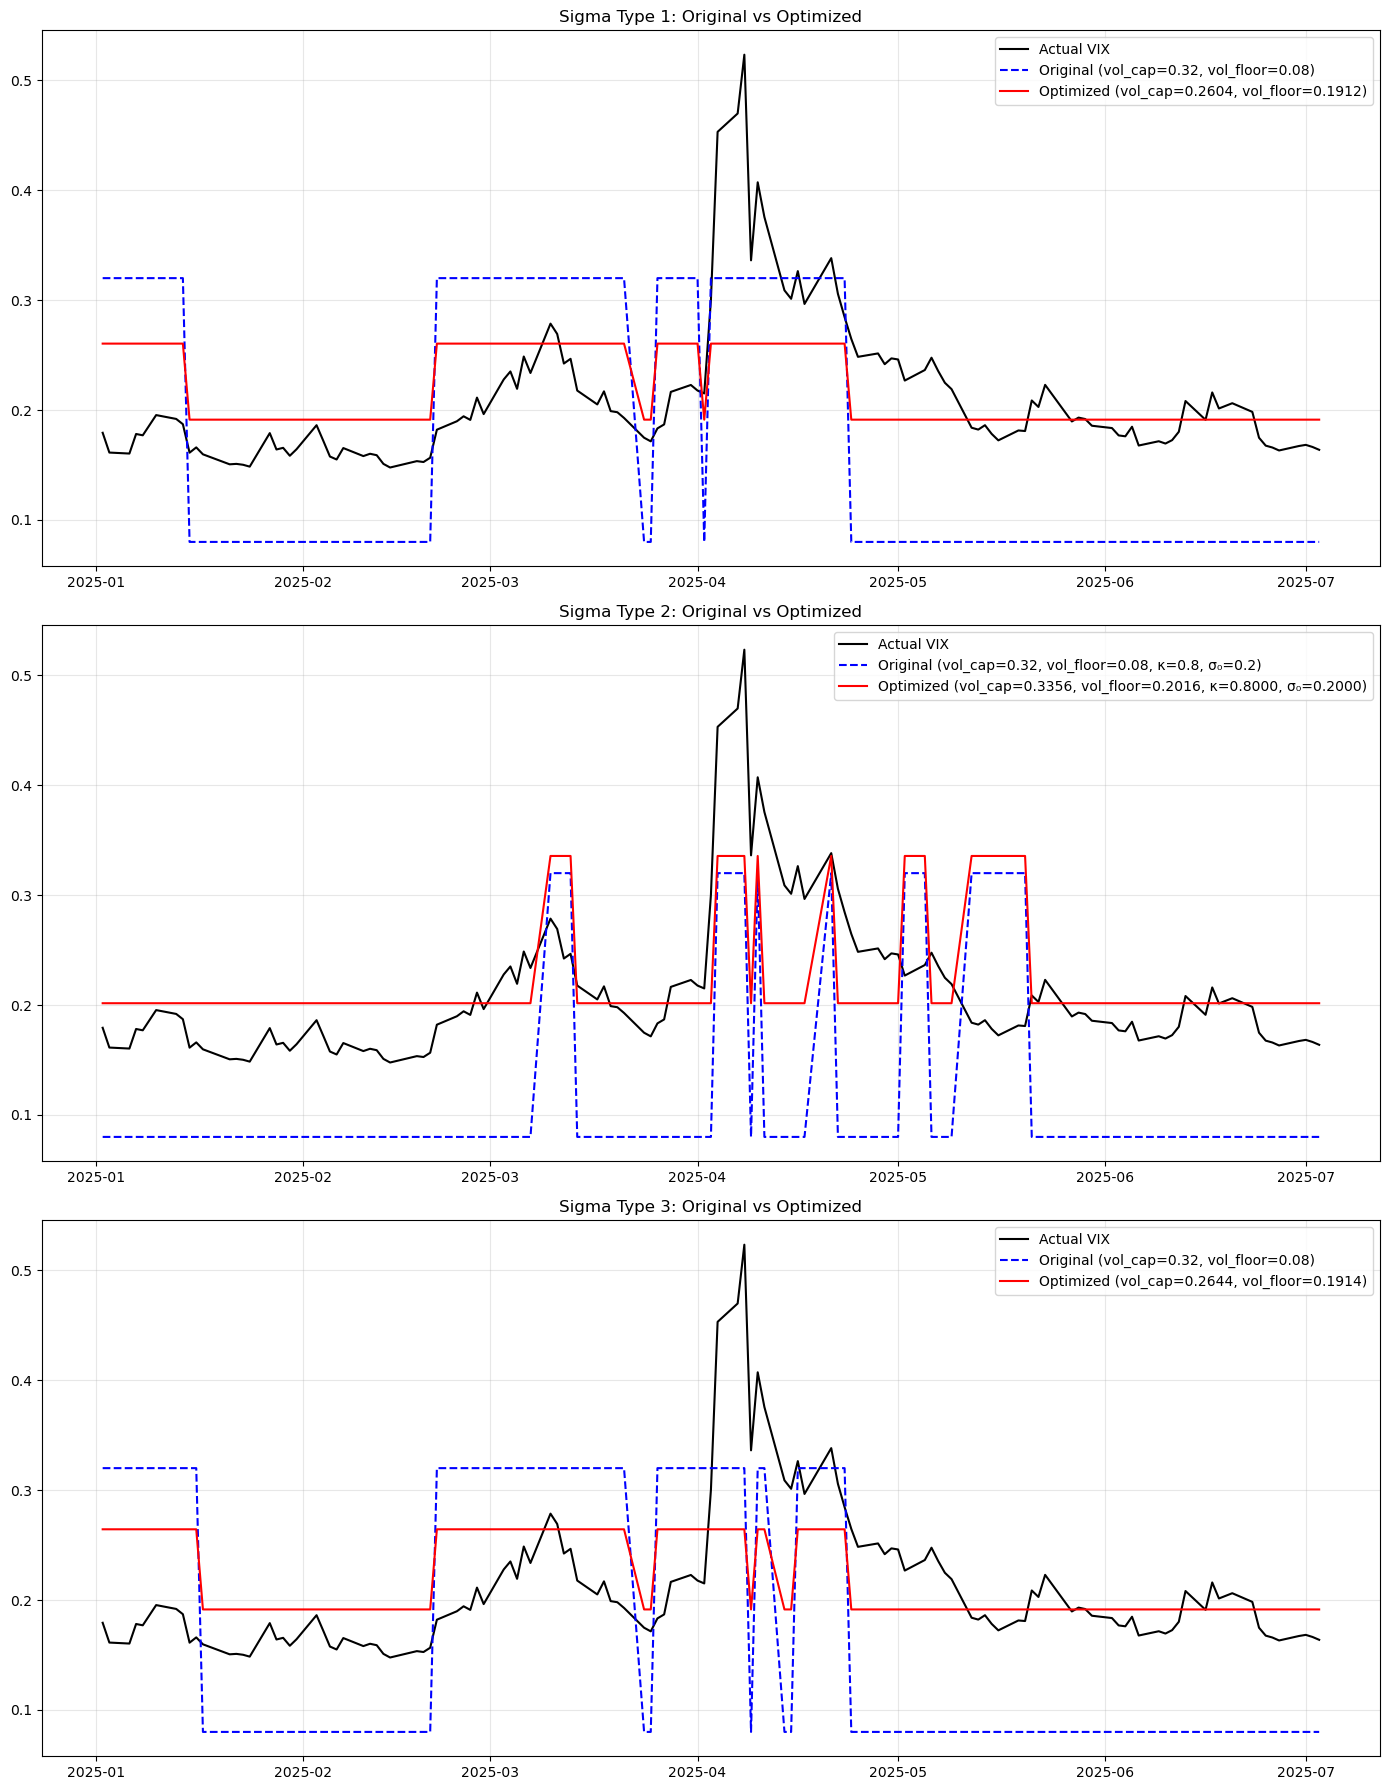


--- Ensemble Model Performance ---
Weights: Type 1 = 0.35, Type 2 = 0.32, Type 3 = 0.33
Optimized Sigma Ensemble - RMSE: 0.0543, MAE: 0.0420, R²: 0.3011


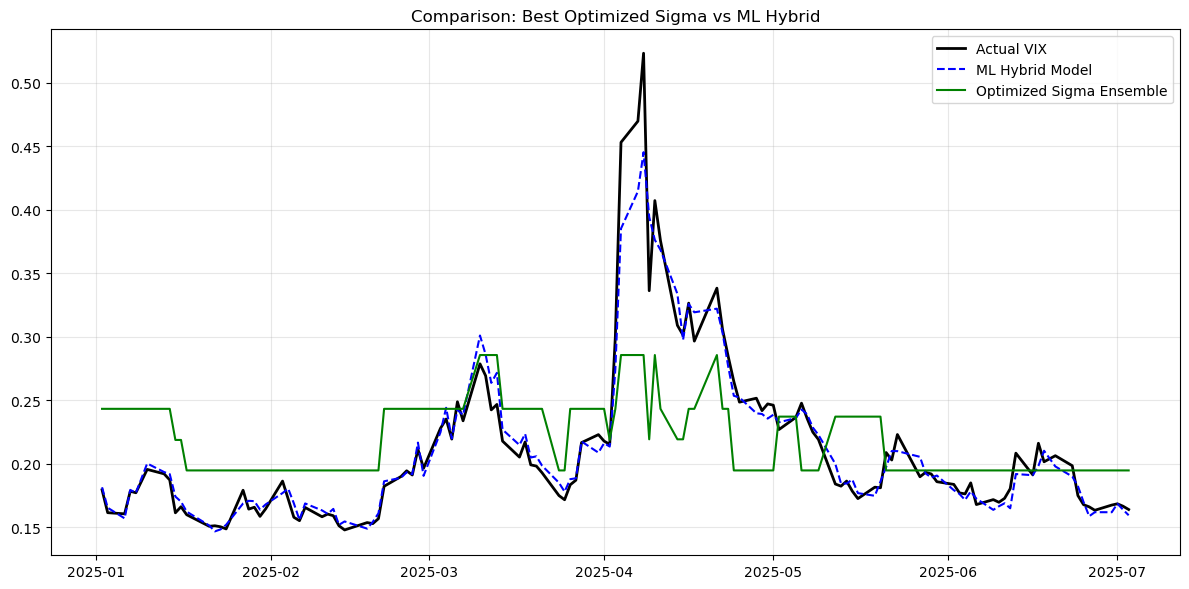


--- Final Comparison ---
ML Hybrid Model: RMSE = 0.0147, R² = 0.9487
Optimized Sigma Ensemble: RMSE = 0.0543, R² = 0.3011

--- Optimized Parameters Summary ---
   Parameter Sigma Type 1  Sigma Type 2 Sigma Type 3
0    vol_cap      0.26043      0.335630     0.264357
1  vol_floor     0.191243      0.201642      0.19144
2      kappa          N/A      0.800000          N/A
3     sigma0          N/A      0.200000          N/A


In [16]:
# Optimize parameters for our three sigma models
from scipy.optimize import minimize

# Define objective functions for each sigma model type
def objective_sigma1(params, s, x):
    """
    Optimize vol_cap and vol_floor for sigma_type1: σ(t,S,X) = vol_cap if S <= X else vol_floor
    
    Args:
        params: [vol_cap, vol_floor]
        s: SPX prices
        x: Reference values (VWAP)
    
    Returns:
        MSE between predicted sigma and actual VIX
    """
    vol_cap, vol_floor = params
    sigma_pred = np.where(s <= x, vol_cap, vol_floor)
    return mean_squared_error(model_df['VIX'], sigma_pred)

def objective_sigma2(params, s, x, delta):
    """
    Optimize vol_cap, vol_floor, kappa, and sigma0 for sigma_type2:
    σ(t,S,X) = vol_cap if abs(S/X - 1) > kappa * sigma0 * sqrt(Delta) else vol_floor
    
    Args:
        params: [vol_cap, vol_floor, kappa, sigma0]
        s: SPX prices
        x: Reference values (VWAP)
        delta: Time window in years
    
    Returns:
        MSE between predicted sigma and actual VIX
    """
    vol_cap, vol_floor, kappa, sigma0 = params
    threshold = kappa * sigma0 * np.sqrt(delta)
    sigma_pred = np.where(abs(s / x - 1) > threshold, vol_cap, vol_floor)
    return mean_squared_error(model_df['VIX'], sigma_pred)

def objective_sigma3(params, s, min_val, max_val):
    """
    Optimize vol_cap and vol_floor for sigma_type3:
    σ(t,S,X) = vol_cap if (S - min) / (max - min) <= 0.5 else vol_floor
    
    Args:
        params: [vol_cap, vol_floor]
        s: SPX prices
        min_val: Minimum price in window
        max_val: Maximum price in window
    
    Returns:
        MSE between predicted sigma and actual VIX
    """
    vol_cap, vol_floor = params
    position = (s - min_val) / (max_val - min_val + 1e-8)  # Avoid division by zero
    sigma_pred = np.where(position <= 0.5, vol_cap, vol_floor)
    return mean_squared_error(model_df['VIX'], sigma_pred)

# Set up constraints and initial guesses
print("Optimizing sigma model parameters...")

# Initial guesses based on typical VIX ranges
initial_vol_cap = 0.32  # ~32% volatility
initial_vol_floor = 0.08  # ~8% volatility
initial_kappa = 0.8
initial_sigma0 = 0.2

# Bounds for parameters (min, max)
bounds_sigma1 = [(0.05, 0.6), (0.02, 0.3)]  # For vol_cap, vol_floor
bounds_sigma2 = [(0.05, 0.6), (0.02, 0.3), (0.1, 2.0), (0.05, 0.4)]  # For vol_cap, vol_floor, kappa, sigma0
bounds_sigma3 = [(0.05, 0.6), (0.02, 0.3)]  # For vol_cap, vol_floor

# Run optimization for each sigma type
# Sigma Type 1: Based on SPX vs VWAP
result_sigma1 = minimize(
    objective_sigma1,
    [initial_vol_cap, initial_vol_floor],
    args=(model_df['SPX'], model_df['VWAP']),
    bounds=bounds_sigma1,
    method='L-BFGS-B'
)

# Sigma Type 2: Based on deviation from VWAP
result_sigma2 = minimize(
    objective_sigma2,
    [initial_vol_cap, initial_vol_floor, initial_kappa, initial_sigma0],
    args=(model_df['SPX'], model_df['VWAP'], Delta),
    bounds=bounds_sigma2,
    method='L-BFGS-B'
)

# Sigma Type 3: Based on position in min-max range
result_sigma3 = minimize(
    objective_sigma3,
    [initial_vol_cap, initial_vol_floor],
    args=(model_df['SPX'], model_df['min'], model_df['max']),
    bounds=bounds_sigma3,
    method='L-BFGS-B'
)

# Extract optimized parameters
opt_vol_cap1, opt_vol_floor1 = result_sigma1.x
opt_vol_cap2, opt_vol_floor2, opt_kappa, opt_sigma0 = result_sigma2.x
opt_vol_cap3, opt_vol_floor3 = result_sigma3.x

# Display optimized parameters
print("\n--- Optimized Parameters ---")
print(f"Sigma Type 1: vol_cap = {opt_vol_cap1:.4f}, vol_floor = {opt_vol_floor1:.4f}")
print(f"Sigma Type 2: vol_cap = {opt_vol_cap2:.4f}, vol_floor = {opt_vol_floor2:.4f}, kappa = {opt_kappa:.4f}, sigma0 = {opt_sigma0:.4f}")
print(f"Sigma Type 3: vol_cap = {opt_vol_cap3:.4f}, vol_floor = {opt_vol_floor3:.4f}")

# Generate optimized sigma predictions for test data
test_sigma1_opt = np.where(test_data['SPX'] <= test_data['VWAP'], opt_vol_cap1, opt_vol_floor1)
threshold_opt = opt_kappa * opt_sigma0 * np.sqrt(Delta)
test_sigma2_opt = np.where(abs(test_data['SPX'] / test_data['VWAP'] - 1) > threshold_opt, opt_vol_cap2, opt_vol_floor2)
test_position = (test_data['SPX'] - test_data['min']) / (test_data['max'] - test_data['min'] + 1e-8)
test_sigma3_opt = np.where(test_position <= 0.5, opt_vol_cap3, opt_vol_floor3)

# Add optimized predictions to test_data
test_data['sigma_type1_opt'] = test_sigma1_opt
test_data['sigma_type2_opt'] = test_sigma2_opt
test_data['sigma_type3_opt'] = test_sigma3_opt

# Evaluate optimized models on test data
print("\n--- Performance of Optimized Sigma Models on Test Data ---")
evaluate_model(test_data['VIX'], test_data['sigma_type1_opt'], "Sigma Type 1 (Optimized)")
evaluate_model(test_data['VIX'], test_data['sigma_type2_opt'], "Sigma Type 2 (Optimized)")
evaluate_model(test_data['VIX'], test_data['sigma_type3_opt'], "Sigma Type 3 (Optimized)")

# Find the best performing optimized sigma model
rmse1 = np.sqrt(mean_squared_error(test_data['VIX'], test_data['sigma_type1_opt']))
rmse2 = np.sqrt(mean_squared_error(test_data['VIX'], test_data['sigma_type2_opt']))
rmse3 = np.sqrt(mean_squared_error(test_data['VIX'], test_data['sigma_type3_opt']))

best_model_idx = np.argmin([rmse1, rmse2, rmse3]) + 1
print(f"\nBest performing sigma model: Type {best_model_idx}")

# Compare original vs optimized models visually
plt.figure(figsize=(14, 18))

plt.subplot(3, 1, 1)
plt.title('Sigma Type 1: Original vs Optimized')
plt.plot(test_data.index, test_data['VIX'], 'k-', label='Actual VIX')
plt.plot(test_data.index, test_data['sigma_type1'], 'b--', label=f'Original (vol_cap={vol_cap}, vol_floor={vol_floor})')
plt.plot(test_data.index, test_data['sigma_type1_opt'], 'r-', label=f'Optimized (vol_cap={opt_vol_cap1:.4f}, vol_floor={opt_vol_floor1:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.title('Sigma Type 2: Original vs Optimized')
plt.plot(test_data.index, test_data['VIX'], 'k-', label='Actual VIX')
plt.plot(test_data.index, test_data['sigma_type2'], 'b--', 
         label=f'Original (vol_cap={vol_cap}, vol_floor={vol_floor}, κ={kappa}, σ₀={sigma0})')
plt.plot(test_data.index, test_data['sigma_type2_opt'], 'r-', 
         label=f'Optimized (vol_cap={opt_vol_cap2:.4f}, vol_floor={opt_vol_floor2:.4f}, κ={opt_kappa:.4f}, σ₀={opt_sigma0:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.title('Sigma Type 3: Original vs Optimized')
plt.plot(test_data.index, test_data['VIX'], 'k-', label='Actual VIX')
plt.plot(test_data.index, test_data['sigma_type3'], 'b--', label=f'Original (vol_cap={vol_cap}, vol_floor={vol_floor})')
plt.plot(test_data.index, test_data['sigma_type3_opt'], 'r-', label=f'Optimized (vol_cap={opt_vol_cap3:.4f}, vol_floor={opt_vol_floor3:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create an ensemble of the optimized sigma models
# Use a weighted average based on the inverse of RMSE
weights = [1/rmse1, 1/rmse2, 1/rmse3]
weights = weights / np.sum(weights)  # Normalize weights

test_data['sigma_ensemble'] = (
    weights[0] * test_data['sigma_type1_opt'] +
    weights[1] * test_data['sigma_type2_opt'] +
    weights[2] * test_data['sigma_type3_opt']
)

print("\n--- Ensemble Model Performance ---")
print(f"Weights: Type 1 = {weights[0]:.2f}, Type 2 = {weights[1]:.2f}, Type 3 = {weights[2]:.2f}")
ensemble_metrics = evaluate_model(test_data['VIX'], test_data['sigma_ensemble'], "Optimized Sigma Ensemble")

# Compare best optimized sigma with ML hybrid model
plt.figure(figsize=(12, 6))
plt.title('Comparison: Best Optimized Sigma vs ML Hybrid')
plt.plot(test_data.index, test_data['VIX'], 'k-', linewidth=2, label='Actual VIX')
plt.plot(test_data.index, test_data['sigma_hybrid'], 'b--', label='ML Hybrid Model')
plt.plot(test_data.index, test_data['sigma_ensemble'], 'g-', label='Optimized Sigma Ensemble')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n--- Final Comparison ---")
print(f"ML Hybrid Model: RMSE = {hybrid_metrics[0]:.4f}, R² = {hybrid_metrics[2]:.4f}")
print(f"Optimized Sigma Ensemble: RMSE = {ensemble_metrics[0]:.4f}, R² = {ensemble_metrics[2]:.4f}")

# Save optimized parameters for future use
optimized_params = {
    'sigma_type1': {
        'vol_cap': opt_vol_cap1,
        'vol_floor': opt_vol_floor1
    },
    'sigma_type2': {
        'vol_cap': opt_vol_cap2,
        'vol_floor': opt_vol_floor2,
        'kappa': opt_kappa,
        'sigma0': opt_sigma0
    },
    'sigma_type3': {
        'vol_cap': opt_vol_cap3,
        'vol_floor': opt_vol_floor3
    },
    'ensemble_weights': {
        'weight1': weights[0],
        'weight2': weights[1],
        'weight3': weights[2]
    }
}

# Display optimized parameters as a DataFrame for easy reference
params_df = pd.DataFrame({
    'Parameter': ['vol_cap', 'vol_floor', 'kappa', 'sigma0'],
    'Sigma Type 1': [opt_vol_cap1, opt_vol_floor1, 'N/A', 'N/A'],
    'Sigma Type 2': [opt_vol_cap2, opt_vol_floor2, opt_kappa, opt_sigma0],
    'Sigma Type 3': [opt_vol_cap3, opt_vol_floor3, 'N/A', 'N/A']
})

print("\n--- Optimized Parameters Summary ---")
print(params_df)

In [ ]:
# 使用Keras创建轻量级神经网络拟合SPX到VIX的关系
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("TensorFlow version:", tf.__version__)

# 准备数据 - 选择特征和目标变量
# features = ['SPX_to_VWAP', 'SPX_to_lag', 'position_in_range', 'SPX']

features = [
    'SPX',
    'VWAP', 'lag', 'min', 'max',
    'SPX_to_VWAP', 'SPX_to_lag', 'position_in_range',
    'SPX_return', 'SPX_return_squared',
    'VIX_lag_1', 'VIX_lag_2', 'VIX_lag_3'
]

X = model_df[features].values
y = model_df['VIX'].values

# 划分训练集和验证集 (80/20分割)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 创建轻量级神经网络模型
def create_nn_model():
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)  # 输出层，预测VIX
    ])
    
    # 编译模型
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# 创建模型
nn_model = create_nn_model()
nn_model.summary()

# 训练模型
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
    ]
)

# 绘制训练历史
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# 评估模型性能 - 使用训练和测试数据
y_train_pred = nn_model.predict(X_train_scaled).flatten()
y_val_pred = nn_model.predict(X_val_scaled).flatten()

# 计算误差指标
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training - RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Validation - RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")

# 在2025年测试数据上评估模型
X_test_nn = test_data[features].values
X_test_scaled = scaler.transform(X_test_nn)
y_test_pred_nn = nn_model.predict(X_test_scaled).flatten()

# 计算测试误差
test_rmse = np.sqrt(mean_squared_error(test_data['VIX'], y_test_pred_nn))
test_mae = mean_absolute_error(test_data['VIX'], y_test_pred_nn)
test_r2 = r2_score(test_data['VIX'], y_test_pred_nn)

print(f"Test Data (2025) - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

# 将神经网络预测添加到测试数据中
test_data['sigma_nn'] = y_test_pred_nn

# 比较神经网络与之前最佳模型的表现
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.title('VIX - 2025 TestData')
plt.plot(test_data.index, test_data['VIX'], 'k-', linewidth=2, label='Real VIX')
plt.plot(test_data.index, test_data['sigma_hybrid'], 'b--', label='Mixed Model')
plt.plot(test_data.index, test_data['sigma_nn'], 'r-', label='Neural Network')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.title('Prediction Error')
plt.plot(test_data.index, test_data['VIX'] - test_data['sigma_hybrid'], 'b--', label='Hybrid')
plt.plot(test_data.index, test_data['VIX'] - test_data['sigma_nn'], 'r-', label='NN Error')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 绘制散点图，查看模型预测与实际值的关系
plt.figure(figsize=(10, 6))
plt.scatter(test_data['VIX'], test_data['sigma_nn'], alpha=0.6)
plt.plot([test_data['VIX'].min(), test_data['VIX'].max()], 
         [test_data['VIX'].min(), test_data['VIX'].max()], 'k--')
plt.xlabel('Real VIX')
plt.ylabel('NN Prediction')
plt.title('Comparision')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 获取第一层权重
first_layer_weights = nn_model.layers[0].get_weights()[0]  # shape: [特征数量, 隐藏层节点数]

# 计算每个特征的权重绝对值平均值
feature_importance = np.mean(np.abs(first_layer_weights), axis=1)

# 创建特征重要性DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# 按重要性排序并可视化
importance_df = importance_df.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Neural Network Feature Importance')
plt.xlabel('Abs Value of Avg Weights')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [ ]:
# 方法2：自定义排列重要性 (Permutation Importance)
# 针对Keras模型的自定义实现，不依赖sklearn.inspection.permutation_importance

def custom_permutation_importance(model, X, y, n_repeats=10):
    # 计算基线分数 (使用MSE作为评估指标)
    baseline_pred = model.predict(X).flatten()
    baseline_mse = np.mean((y - baseline_pred) ** 2)
    
    n_features = X.shape[1]
    importances = np.zeros((n_repeats, n_features))
    
    for i in range(n_repeats):
        for j in range(n_features):
            # 创建打乱的数据集
            X_permuted = X.copy()
            # 打乱单个特征的值
            np.random.shuffle(X_permuted[:, j])
            
            # 预测并计算新的MSE
            perm_pred = model.predict(X_permuted).flatten()
            perm_mse = np.mean((y - perm_pred) ** 2)
            
            # 性能下降 = 打乱后MSE - 基线MSE (越大表示特征越重要)
            importances[i, j] = perm_mse - baseline_mse
    
    # 计算平均值和标准差
    mean_importances = np.mean(importances, axis=0)
    std_importances = np.std(importances, axis=0)
    
    return {
        'importances_mean': mean_importances,
        'importances_std': std_importances
    }

perm_result = custom_permutation_importance(
    nn_model, X_val_scaled, y_val, n_repeats=5
)

perm_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': perm_result['importances_mean'],
    'Std': perm_result['importances_std']
})

# 按重要性排序并可视化
perm_importance_df = perm_importance_df.sort_values('Importance', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], 
         xerr=perm_importance_df['Std'], capsize=5)
plt.title('Feature Importance')
plt.xlabel('MSE Increase)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("Top 5 ：")
print(perm_importance_df.head(5))

In [ ]:
# 使用Keras创建改进的神经网络拟合SPX到VIX的关系
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("TensorFlow version:", tf.__version__)

# 准备数据 - 选择特征和目标变量
features = [
    'SPX',
    'VWAP', 'lag', 'min', 'max',
    'SPX_to_VWAP', 'SPX_to_lag', 'position_in_range',
    'SPX_return', 'SPX_return_squared',
    'VIX_lag_1', 'VIX_lag_2', 'VIX_lag_3'
]

X = model_df[features].values
y = model_df['VIX'].values

# 划分训练集和验证集 (80/20分割)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 创建改进的神经网络模型
def create_improved_nn_model():
    # 设置L2正则化参数
    l2_reg = 0.001
    
    model = keras.Sequential([
        # 第一隐藏层: 64神经元 + 批归一化 + LeakyReLU
        layers.Dense(64, kernel_regularizer=regularizers.l2(l2_reg), input_shape=(X_train_scaled.shape[1],)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.3),
        
        # 第二隐藏层: 32神经元 + 批归一化 + LeakyReLU
        layers.Dense(32, kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.2),
        
        # 第三隐藏层: 16神经元 + 批归一化 + LeakyReLU
        layers.Dense(16, kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.1),
        
        # 输出层: 线性激活
        layers.Dense(1)
    ])
    
    # 设置动态学习率
    initial_learning_rate = 0.005
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100,
        decay_rate=0.9,
        staircase=True)
    
    # 编译模型
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# 创建模型
improved_nn_model = create_improved_nn_model()
improved_nn_model.summary()

# 训练模型
history = improved_nn_model.fit(
    X_train_scaled, y_train,
    epochs=200,  # 增加最大epoch数，让早停机制决定何时停止
    batch_size=64,
    validation_data=(X_val_scaled, y_val),
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,  # 增加耐心值
            restore_best_weights=True,
            min_delta=0.001  # 设置最小改进阈值
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )
    ]
)

# 绘制训练历史
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# 评估模型性能 - 使用训练和测试数据
y_train_pred = improved_nn_model.predict(X_train_scaled).flatten()
y_val_pred = improved_nn_model.predict(X_val_scaled).flatten()

# 计算误差指标
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training - RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Validation - RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")

# 在2025年测试数据上评估模型
X_test_nn = test_data[features].values
X_test_scaled = scaler.transform(X_test_nn)
y_test_pred_nn = improved_nn_model.predict(X_test_scaled).flatten()

# 计算测试误差
test_rmse = np.sqrt(mean_squared_error(test_data['VIX'], y_test_pred_nn))
test_mae = mean_absolute_error(test_data['VIX'], y_test_pred_nn)
test_r2 = r2_score(test_data['VIX'], y_test_pred_nn)

print(f"Test Data (2025) - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

# 将神经网络预测添加到测试数据中
test_data['sigma_nn_improved'] = y_test_pred_nn

# 比较神经网络与之前最佳模型的表现
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.title('VIX预测比较 - 2025测试数据')
plt.plot(test_data.index, test_data['VIX'], 'k-', linewidth=2, label='实际VIX')
plt.plot(test_data.index, test_data['sigma_hybrid'], 'b--', label='混合模型')
plt.plot(test_data.index, test_data['sigma_nn_improved'], 'r-', label='改进神经网络')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.title('预测误差分析')
plt.plot(test_data.index, test_data['VIX'] - test_data['sigma_hybrid'], 'b--', label='混合模型误差')
plt.plot(test_data.index, test_data['VIX'] - test_data['sigma_nn_improved'], 'r-', label='改进神经网络误差')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 绘制散点图，查看模型预测与实际值的关系
plt.figure(figsize=(10, 6))
plt.scatter(test_data['VIX'], test_data['sigma_nn_improved'], alpha=0.6)
plt.plot([test_data['VIX'].min(), test_data['VIX'].max()], 
         [test_data['VIX'].min(), test_data['VIX'].max()], 'k--')
plt.xlabel('实际VIX')
plt.ylabel('改进神经网络预测')
plt.title('改进神经网络预测与实际VIX对比')
plt.grid(True, alpha=0.3)
plt.show()